In [3]:
# Import the required modules
from IPython.display import clear_output
import PIL.Image
from io import BytesIO
import IPython.display

import cv2
import time
from scipy.stats import mode
import heapq as hq
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# UTILITY FUNCTIONS

In [4]:
def factors(chosen, currentnum=None, numbers=None): 
    # Recursion start, always append 1 and start with 2
    if numbers is None:
        numbers = [1]
        currentnum = 2
    # We're at the last value, it's always divisible by itself so
    # append it and return
    if currentnum == chosen:
        numbers.append(currentnum)
        return numbers
    else:
        # Check if the chosen item is divisible by the current number
        if chosen % currentnum == 0:
            numbers.append(currentnum)
        # Always continue with the next number:
        currentnum += 1
        return factors(chosen, currentnum, numbers)

factors(1079)

[1, 13, 83, 1079]

In [5]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, times=2, r=True, fmt='jpeg'):
    old_shape = a.shape
    if len(a.shape) is 3:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        old_shape = a.shape[:-1]
    if r:
        new_shape = flip(rint(divide(old_shape, times)).astype(int))
        a = cv2.resize(a, tuple(new_shape.tolist()))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [6]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    if not ret:
        raise KeyboardInterrupt()
    
    #flip image for natural viewing
    #frame = cv2.flip(frame, 1)
    
    return frame

In [7]:
yellow = (255, 0, 255)
red = (0, 0, 255)
green = (0, 255, 0)
def draw_region(frame, h, w, color):
    frame = cv2.line(frame_show, (2000, h), (0, h), color, 5)
    frame = cv2.line(frame_show, (2000, h-w), (0, h-w), color, 5)
    return frame

In [8]:
# PROCESS FUNCTIONS

In [9]:
def generate_LUT(gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    def adjust_gamma(image):
        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)
    return adjust_gamma

In [10]:
def DoG(frame, s=1, stride=0):
    #run a 5x5 gaussian blur then a 3x3 gaussian blr
    sB = (s+1+stride)*2+1
    sS = (s)*2+1
    blurB = cv2.GaussianBlur(frame,(sB,sB),0)
    blurS = cv2.GaussianBlur(frame,(sS,sS),0)

    return blurB - blurS

In [11]:
def generate_morphOps():
    se_c = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    se_vl = np.array([[0,1,0],[0,1,0],[0,1,0]], np.ubyte)
    def morphOps(frame, it):
        frame_out = cv2.morphologyEx(frame, cv2.MORPH_OPEN, se_c, iterations=1)
        frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_vl, iterations=it)
        frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_DILATE, se_vl, iterations=it)
        return frame_out
    return morphOps

In [12]:
def Unwarp(frame, ltc, rtc):
    h = frame.shape[0]
    w = frame.shape[1]
    pts_src = np.array([[ltc, 0], [0, h], [rtc, h],[w, 0]])
    pts_dst = np.array([[0, 0],[0, h],[w, h],[w, 0]])

    h, status = cv2.findHomography(pts_src, pts_dst)
    frame_out = cv2.warpPerspective(frame, h, (frame.shape[1],frame.shape[0]))
    return frame_out

In [13]:
def proposeScan(frame_p, scan_line_h, bins_count=80, bin_threshold=350):
    #Get full frame scan line
    scan_line = frame_p[scan_line_h,:]

    # Find first peaks from center
    # Find peaks
    bin_width = round(len(scan_line)/bins_count)
    scan_bins = sum(split(scan_line, bins_count), 1) # Grouped in 50 bins
    scan_bins_peaks = where(scan_bins>bin_threshold)[0]
    # Break peaks indexes to left an right from center
    # And get peaks nearest to center
    center_bin = round(bins_count/2)
    left_peak_predicate = scan_bins_peaks <= center_bin
    right_peak_predicate = scan_bins_peaks > center_bin
    if not any(left_peak_predicate) or not any(right_peak_predicate):
        return False, None, None
    left_peak = int(scan_bins_peaks[left_peak_predicate][-1]*bin_width)
    right_peak = int(scan_bins_peaks[right_peak_predicate][0]*bin_width)

    # Calculate various conditions
    cavity_width = right_peak-left_peak
    cavity_weight = sum(frame_p[scan_line_h,left_peak:right_peak])
    
    if cavity_width > 800:
        left_peak = max(0, left_peak)
        right_peak = min(frame_p.shape[1], right_peak)
        return True, left_peak, right_peak
    else:
        return False, None, None

In [39]:
def get_x_by_y(p, y):
    if p[1][0] == p[0][0]:
        return p[0][0]
    else:
        k = (p[1][1] - p[0][1]) / (p[1][0] - p[0][0])
        b = p[0][1] - k * p[0][0]    
        return int((y-b)/k)
    
def merge_points_to_line(frame_p, scan_line_h, angle_thresh = np.pi*0.4, window = 50): 
    h_p,w_p = frame_p.shape
    h_top = max(0, scan_line_h - window)
    h_bottom = min(h_p, scan_line_h + window)
    frame = frame_p[h_top:h_bottom,...].copy()
    h,w = frame.shape
    pc = np.asarray((w//2,h//2))

    frame = cv2.Canny(frame, 10, 200, None, 3)
    lines = cv2.HoughLinesP(frame, rho=1, theta=np.pi/180, 
                            threshold=30, minLineLength=int(window*0.5), maxLineGap=10)
    lines_left = []
    lines_right = []
    x_left = None
    x_right = None

    if lines is None:
        return x_left, x_right
    
    for i in range(0, len(lines)):
        p1, p2 = np.asarray([lines[i][0][0], lines[i][0][1]]), np.asarray([lines[i][0][2], lines[i][0][3]])
        angle = math.atan2((p2[1]-p1[1]),(p2[0] - p1[0]))
        
        if (angle < angle_thresh) and (angle > -angle_thresh):
            continue        
           
        d = norm(np.cross(p2-p1, p1-pc))/norm(p2-p1)

        if p1[0] <= pc[0]:
            hq.heappush(lines_left, (d,[p1,p2]))
        else:
            hq.heappush(lines_right,(d,[p1,p2]))      

    if len(lines_left) >0:
        p = hq.nsmallest(1, lines_left)[0][1]  
        x_left = get_x_by_y(p, h//2)

    if len(lines_right) >0:
        p = hq.nsmallest(1, lines_right)[0][1]
        x_right = get_x_by_y(p, h//2)
       
    return x_left, x_right

In [40]:
#Kartashev: interpolation and gluing
from scipy.interpolate import UnivariateSpline

def glue(sum_plate, region):
    old_indices = arange(0, region.shape[1])
    new_indices = np.linspace(0, region.shape[1]-1, sum_plate.shape[1])
    for line_i in range(region.shape[0]):
        line = region[line_i,:]
        spl = UnivariateSpline(old_indices, line, k=3, s=0)
        new_line = spl(new_indices).astype(np.uint8)
        sum_plate = np.vstack((sum_plate, [new_line]))
    return sum_plate

In [76]:
def generate_process(scan_line_h = 600, scan_line_w = 75):
    adjust_gamma = generate_LUT(4)
    morphOps = generate_morphOps()
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16,16))  
    found_plate = False
    lost_plate_frames = 0
    llp, lrp = None, None
    def process(frame_in):
        nonlocal found_plate
        nonlocal lost_plate_frames
        nonlocal llp, lrp

        frame_out = cv2.cvtColor(frame_in, cv2.COLOR_BGR2GRAY)
        #frame_out = clahe.apply(frame_out)
        #frame_out = cv2.equalizeHist(frame_out)
        #frame_out = adjust_gamma(frame_out)
        frame_out = clahe.apply(frame_out)
        frame_out = DoG(frame_out, 2, 9)
        frame_out = morphOps(frame_out, 6)
        
        frame_out = Unwarp(frame_out, 140, frame_out.shape[1]+160)
        frame_in = Unwarp(frame_in, 140, frame_out.shape[1]+160)
        
        lcm = 260
        rcm = frame_out.shape[1]-260
        frame_out = frame_out[:, lcm:rcm]
        frame_in = frame_in[:, lcm:rcm]
        
        if found_plate:
            ret = False
            voters = linspace(scan_line_h-scan_line_w, scan_line_h, 10, dtype=int)
            votes = [proposeScan(frame_out, scan_line_h, 140, 150) for scan_line_h in voters]
            valid_votes = [vote[1:] for vote in votes if vote[0]]
            valid_votes.append(merge_points_to_line(frame_out, scan_line_h))
            if len(valid_votes) >= 5:
                consent_vote = tuple(mode(valid_votes).mode[0])
                consent_strength = min(mode(valid_votes).count[0])
                if(consent_strength >= 3):
                    ret = True
                    lp, rp = consent_vote
        else:
            lp, rp = merge_points_to_line(frame_out, scan_line_h)
            print(lp)
            if lp is None or rp is None:
                ret = False
            else:
                ret = True
            #ret, lp, rp = proposeScan(frame_out, scan_line_h, 200, 150)
        
        if ret:
            llp, lrp = lp, rp
            lost_plate_frames = 0
            if not found_plate:
                found_plate = True
        elif found_plate and lost_plate_frames < 2: # Missing region for several frames
            lp, rp = llp, lrp
            lost_plate_frames += 1            
        else: # Missed region
            found_plate = False
            lost_plate_frames = 0
            llp, lrp = None, None

        if(found_plate):
            # Extract proposed line
            # Kartashev: in grayscale for simplier interpolation
            frame_gray = cv2.cvtColor(frame_in, cv2.COLOR_BGR2GRAY)
            print(lp)
            scanned_line = frame_gray[scan_line_h-scan_line_w:scan_line_h,lp:rp]
            return frame_out, scanned_line, lost_plate_frames != 0
        else:
            return frame_out, None, False
    return process

In [77]:
# Work area

In [78]:
input_file_path = 'Дефекты кромки1.cva'
vid = cv2.VideoCapture(input_file_path)

In [79]:
# Seek needed frame
# 150, 30 - 2 plate
vid.set(cv2.CAP_PROP_POS_FRAMES,125)
frame = get_frame(vid)

682
682


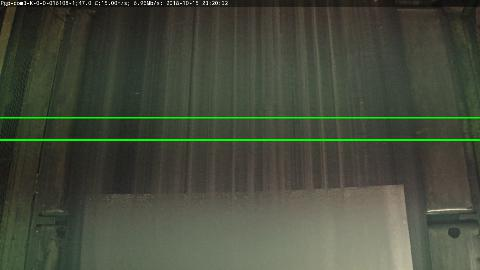

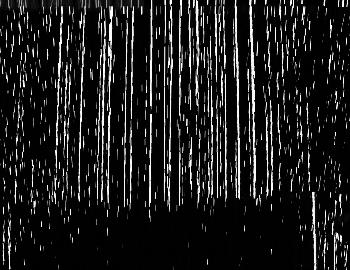

In [ ]:
scan_line_h = 560
scan_line_w = 90
process = generate_process(scan_line_h, scan_line_w)
frames_to_play = 50
found_plate = None
sum_plate = None
frame_skip = False
plates_count = 0
status = ''
try:
    while(frames_to_play):
        t1 = time.time()
        
        # Capture frame-by-frame
        frame = get_frame(vid)
                   
        #frames_to_play -= 1

        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame_p, line, m = process(frame)
        frame_show = frame.copy()
        if line is not None:
            if m:
                frame_show = draw_region(frame_show, scan_line_h, scan_line_w, yellow)
            else:
                frame_show = draw_region(frame_show, scan_line_h, scan_line_w, green)
            if not found_plate:
                status = 'plate have started'
                found_plate = True
                sum_plate = line
            else:
                #пока отображаем только последнюю. И в Grayscale, так проще делать интерполяцию                
                sum_plate = glue(sum_plate, line)
                status = 'appended plate'
        else:
            frame_show = draw_region(frame_show, scan_line_h, scan_line_w, red)
            if found_plate:
                status = 'plate has ended'
                found_plate = False
                cv2.imwrite('plate_%d.tiff' % (plates_count),sum_plate)
                plates_count += 1
            else:
                status = 'No plate'
        
        t2 = time.time()
        showarray(frame_show, 4)
        showarray(frame_p, 4)
        time.sleep(1)
        fps = '%f FPS' % (1/(t2-t1+1e-07))
        #print('%s %s' % (status, fps))
        # Display the frame until new frame is available
        clear_output(wait=True)
except KeyboardInterrupt:
    vid.release()
    print('Stream stopped')
#showarray(sum_plate, 4)

In [62]:
# TEST